# Jax Embedding Tutorial

Now that we can successfully train a neural network that uses embeddings, let's make a version that is exclusively Jax (no Keras weights) and use it as the skeleton of a future tutorial/video.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os
import random

import tensorflow as tf
import jax
import jax.numpy as jnp
import functools
import optax

from flax.core import frozen_dict
from flax import struct
from flax import linen as nn
from flax.training import train_state

from matplotlib import pyplot as plt

tf.__version__

'2.7.0'

In [2]:
ratings_df = pd.read_csv("data/movie-lens/rating.csv", usecols=['userId', 'movieId', 'rating', 'y'])
movies_df = pd.read_csv("data/movie-lens/movie.csv", usecols=['movieId', 'title', 'year'])
df = ratings_df.merge(movies_df, on='movieId').sort_values(by='userId')

In [3]:
# Shuffle
df = df.sample(frac=1, random_state=1) 
# First 50,000 for test
test_df = df.iloc[:50000]
# Rest for train
train_df = df.iloc[50000:]

n_movies = len(df.movieId.unique())
n_users = len(df.userId.unique())
print(
    "{1:,} distinct users rated {0:,} different movies (total ratings = {2:,})".format(
        n_movies, n_users, len(df),
    )
)

138,493 distinct users rated 26,744 different movies (total ratings = 20,000,263)


In [4]:
@struct.dataclass
class MovieLensConfig:
  """Global hyperparameters for our MovieLens Model"""
  users_size: int = n_users + 1   # 138,494 (+1 because we are 1-indexed)
  movies_size: int = n_movies + 0 # 26,744  (+0 because we are 0-indexed)
  emb_dim: int = 8
  dense_size_0: int = 32
  dense_size_1: int = 4
  out_size: int = 1
  num_epochs: int = 20
  batch_size: int = 5000
  lr: float = 0.005
  momentum: float = 0.1

In [5]:
class MovieLensModel(nn.Module):
  """A simple embedding model."""

  config: MovieLensConfig

  @nn.compact
  def __call__(self, user_id, movie_id):
    
    cfg = self.config
    
    user_id = user_id.astype('int32')
    user_emb = nn.Embed(num_embeddings=cfg.users_size, embedding_init=nn.initializers.xavier_uniform(), features=cfg.emb_dim, name='user')(user_id)
    
    movie_id = movie_id.astype('int32')
    movie_emb = nn.Embed(num_embeddings=cfg.movies_size, embedding_init=nn.initializers.xavier_uniform(), features=cfg.emb_dim, name='movie')(movie_id)
    
    x = jnp.concatenate((user_emb, movie_emb), axis=-1)
    x = jnp.squeeze(x)
        
    x = nn.Dense(cfg.dense_size_0, kernel_init=nn.initializers.kaiming_uniform())(x)
    x = nn.relu(x)
    x = nn.Dense(cfg.dense_size_1, kernel_init=nn.initializers.kaiming_uniform())(x)
    x = nn.relu(x)
    x = nn.Dense(cfg.out_size, kernel_init=nn.initializers.kaiming_uniform())(x)

    return x

In [6]:
def create_train_state(rng, config):
  """Creates initial `TrainState`."""
  model = MovieLensModel(config)
  user_id_fake = jnp.zeros((5,1), jnp.int32)
  movie_id_fake = jnp.zeros((5,1), jnp.int32)
  # Pass fake values through our model to initialize the parameters
  params = model.init(rng, user_id_fake, movie_id_fake)['params']
  
  # TODO(joshvarty): Consider other optimizers.
  tx = optax.adam(config.lr)
  return train_state.TrainState.create(
      apply_fn=model.apply, params=params, tx=tx)

In [7]:
@functools.partial(jax.jit, static_argnums=(0))
def apply_model(cfg, state, user_id, movie_id, rating):
  
  def loss_fn(params):
    logits = MovieLensModel(cfg).apply({'params': params}, user_id, movie_id)
    #loss = jnp.mean(optax.l2_loss(predictions=logits, targets=rating))
    loss = jnp.mean(jnp.square(logits - rating))
    return loss, logits
  
  grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
  (loss, logits), grads = grad_fn(state.params)
  mae = jnp.mean(jnp.abs(logits - rating))
  return grads, loss, mae

In [8]:
@jax.jit
def update_model(state, grads):
  return state.apply_gradients(grads=grads)

In [9]:
def train_epoch(cfg, state, train_df, rng):
  """Train for a single epoch."""
  train_df_size = len(train_df)
  steps_per_epoch = train_df_size // cfg.batch_size
  
  perms = jax.random.permutation(rng, train_df_size)
  perms = perms[:steps_per_epoch * cfg.batch_size]  # skip incomplete batch
  perms = perms.reshape((steps_per_epoch, cfg.batch_size))
  
  epoch_loss = []
  epoch_mae = []  

  for perm in perms:
    # x
    batch_user_id = np.expand_dims(train_df.iloc[perm]['userId'].values, 1)
    batch_movie_id = np.expand_dims(train_df.iloc[perm]['movieId'].values, 1)
    # y
    batch_rating = np.expand_dims(train_df.iloc[perm]['y'].values, 1)
    

    grads, loss, mae = apply_model(cfg, state, batch_user_id, batch_movie_id, batch_rating)
    state = update_model(state, grads)
    
    user_emb_new = state.params['user']['embedding']
    movie_emb_new = state.params['movie']['embedding']
    
    epoch_loss.append(loss)
    epoch_mae.append(mae)
    
  train_loss = np.mean(epoch_loss)
  train_mae = np.mean(epoch_mae)
  return state, train_loss, train_mae

In [10]:
def train_and_evaluate(config, state, train_df, test_df):
  rng = jax.random.PRNGKey(0)
  rng, init_rng = jax.random.split(rng)
  
  train_maes = []
  test_maes = []
  
  for epoch in range(1, config.num_epochs + 1):
    rng, input_rng = jax.random.split(rng)
    state, train_loss, train_mae = train_epoch(config, state, train_df, rng)
    
    user_id = np.expand_dims(test_df['userId'].values, 1)
    movie_id = np.expand_dims(test_df['movieId'].values, 1)
    rating = np.expand_dims(test_df['y'].values, 1)
    _, test_loss, test_mae = apply_model(config, state, user_id, movie_id, rating)
    
    train_maes.append(train_mae)
    test_maes.append(test_mae)
    
    print(
        'epoch:% 3d, train_loss: %.4f, train_mae: %.4f, test_loss: %.4f, test_mae: %.4f'
        % (epoch, train_loss, train_mae, test_loss, test_mae))
    
  return state, train_maes, test_maes

In [11]:
# Check if we can create trainstate
config = MovieLensConfig()
rng = jax.random.PRNGKey(0)
rng, init_rng = jax.random.split(rng)
state = create_train_state(init_rng, config)
# Train Jax model with Keras weights.
state, train_maes, test_maes = train_and_evaluate(config, state, train_df, test_df)

epoch:  1, train_loss: 0.7188, train_mae: 0.6502, test_loss: 0.6855, test_mae: 0.6328
epoch:  2, train_loss: 0.6564, train_mae: 0.6197, test_loss: 0.6621, test_mae: 0.6215
epoch:  3, train_loss: 0.6283, train_mae: 0.6058, test_loss: 0.6504, test_mae: 0.6151
epoch:  4, train_loss: 0.6132, train_mae: 0.5980, test_loss: 0.6458, test_mae: 0.6130
epoch:  5, train_loss: 0.6035, train_mae: 0.5930, test_loss: 0.6438, test_mae: 0.6112
epoch:  6, train_loss: 0.5965, train_mae: 0.5893, test_loss: 0.6421, test_mae: 0.6115
epoch:  7, train_loss: 0.5913, train_mae: 0.5866, test_loss: 0.6425, test_mae: 0.6100
epoch:  8, train_loss: 0.5871, train_mae: 0.5843, test_loss: 0.6418, test_mae: 0.6101
epoch:  9, train_loss: 0.5837, train_mae: 0.5825, test_loss: 0.6419, test_mae: 0.6105
epoch: 10, train_loss: 0.5809, train_mae: 0.5810, test_loss: 0.6407, test_mae: 0.6098
epoch: 11, train_loss: 0.5785, train_mae: 0.5797, test_loss: 0.6406, test_mae: 0.6085
epoch: 12, train_loss: 0.5764, train_mae: 0.5786, test

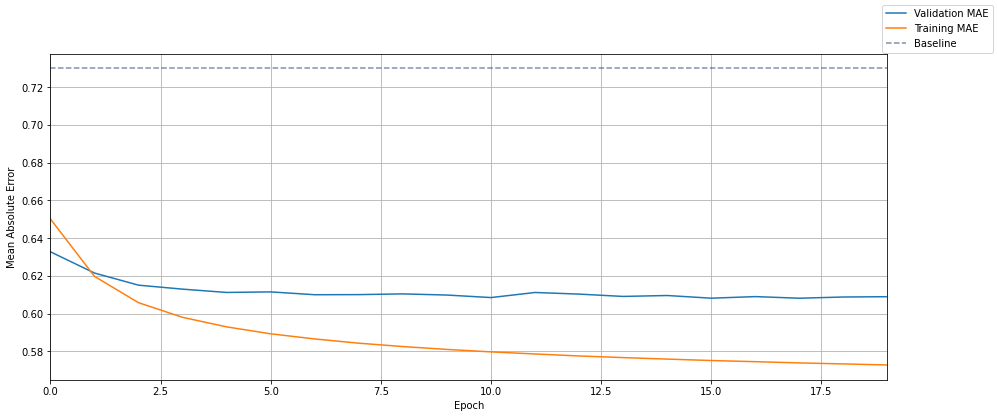

In [12]:
epoch_iota = np.arange(len(train_maes))

fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(epoch_iota, test_maes, label='Validation MAE')
ax.plot(epoch_iota, train_maes, label='Training MAE')
ax.set_xlabel('Epoch')
ax.set_ylabel('Mean Absolute Error')
ax.set_xlim(left=0, right=epoch_iota[-1])
baseline_mae = 0.73
ax.axhline(baseline_mae, ls='--', label='Baseline', color='#002255', alpha=.5)
ax.grid()
fig.legend();

## Exploring Embeddings

In [186]:
# Generate predictions against test set.
# Currently not that great or impressive.
# MovieLensModel(config).apply({'params': state.params}, user_ids, movie_ids)

In [144]:
from sklearn.manifold import TSNE
from matplotlib import offsetbox
import matplotlib.patheffects as PathEffects

In [131]:
# Select the top 100 movies by "number of ratings" (ie. not by their score)
top_100_movies = train_df['movieId'].value_counts()[:100]

In [134]:
top_100_movie_embeddings = np.zeros((100,8), dtype=np.float32)
for i, movie_id in enumerate(top_100_movies):
  for j,_ in enumerate(state.params['movie']['embedding'][i]):
    top_100_movie_embeddings[i,j] = float(state.params['movie']['embedding'][movie_id,j])

In [184]:
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(top_100_movie_embeddings)

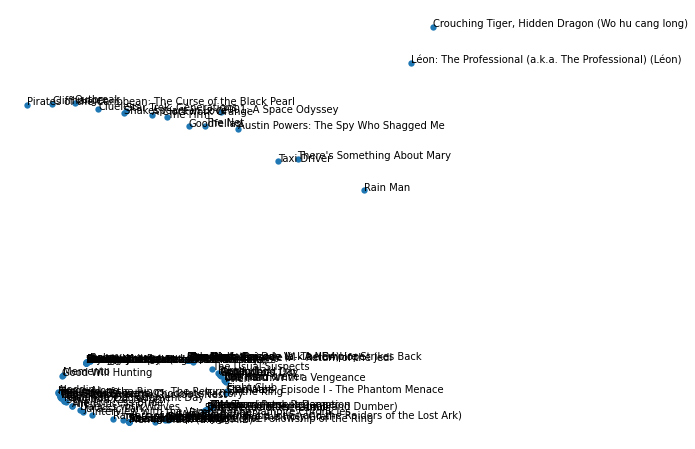

In [185]:
def plot(x):
  
  f = plt.figure(figsize=(8,8))
  ax = plt.subplot(aspect='equal')
  sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40)
  plt.xlim(-25, 25)
  plt.ylim(-25, 25)
  ax.axis('off')
  ax.axis('tight')
  
  for i in range(len(top_100_movies)):
    xtext, ytext = x[i]
    movie_name = train_df[train_df['movieId'] == top_100_movies.keys()[i]]['title'].iloc[0]
    txt = ax.text(xtext, ytext, movie_name, fontsize=10)

  
plot(X_embedded)

These look absolutely fucked. There's no way this is going to be useful. Maybe we have to improve our model before we can get useful visualizations?